In [1]:
#!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#!pip install matplotlib
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms

/home/coartix/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} CUDA device(s).")
    
    # Set the current device (you can choose a specific GPU if you have multiple)
    torch.cuda.set_device(0)  # 0 is the first GPU, change as needed
    current_device = torch.cuda.current_device()
    print(f"Using CUDA device: {current_device}")
else:
    print("CUDA is not available. Using CPU.")

Found 1 CUDA device(s).
Using CUDA device: 0


## I. MNIST Data

### Exercice 1 : Loading Data

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [107]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
  total_samples = n_samples_per_node * nb_nodes
  if total_samples > len(dataset):
    raise ValueError("Not enough samples in dataset")
  idxs = torch.arange(len(dataset))
  if shuffle:
    idxs = torch.randperm(len(dataset))
  idxs = idxs[:total_samples].tolist()

  # Split dataset into nb_nodes datasets
  data_loaders = []
  init_subset = torch.utils.data.Subset(dataset, idxs)
  loader = DataLoader(init_subset, batch_size=n_samples_per_node * nb_nodes, shuffle=shuffle)
  data, labels = next(iter(loader))

  for node_data, node_labels in zip(torch.chunk(data, nb_nodes), torch.chunk(labels, nb_nodes)):
    node_dataset = TensorDataset(node_data, node_labels)
    data_loaders.append(DataLoader(node_dataset, batch_size=batch_size, shuffle=shuffle))

  return data_loaders

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [108]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    digits_per_node = 10//nb_nodes
    digits_split = [digits[i * digits_per_node : (i + 1) * digits_per_node] for i in range(nb_nodes)]
    # If there are remaining digits, distribute them among all nodes starting from the first one
    remaining_digits = digits[digits_per_node * nb_nodes :]
    for i, digit in enumerate(remaining_digits):
        digits_split[i % nb_nodes] = torch.cat((digits_split[i % nb_nodes], digit.view(1)))


    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = DataLoader(dataset, batch_size=nb_nodes*n_samples_per_node, shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):
        # get indices for the digits, i.e. a tensor of boolean values correponding to idx of elements to keep in images_train_mnist and labels_train_mnist
        idx = torch.zeros_like(labels_train_mnist, dtype=torch.bool)
        for digit in digits_split[i]:
            idx |= (labels_train_mnist == digit)
        # create a dataset with the selected elements
        dataset = TensorDataset(images_train_mnist[idx], labels_train_mnist[idx])
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        # append data_splitted with current data loader
        data_splitted.append(loader)
    # return data_splitted with all data loaders
    return data_splitted

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [109]:
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True, shuffle_digits=False):
    # Step 1: Load MNIST Dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    # Step 2: Apply Split Function Based on the Type Parameter
    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle, shuffle_digits=True)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle, shuffle_digits=True)
    else:
        raise ValueError("Invalid type parameter. Use 'iid' or 'non_iid'.")

    return train_loaders, test_loaders

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [110]:
mnist_iid_train, mnist_iid_test = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [111]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

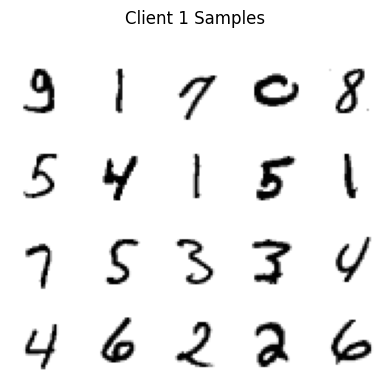

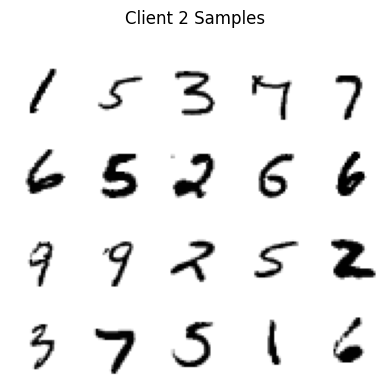

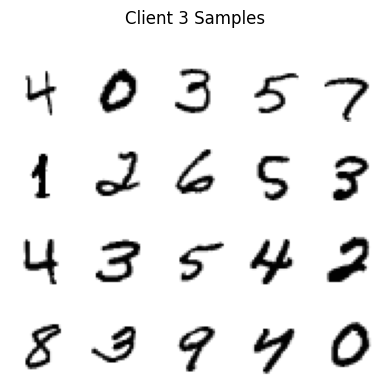

In [112]:
# Plot samples for client 1
plot_samples(next(iter(mnist_iid_train[0])), channel=0, title="Client 1 Samples")

# Plot samples for client 2
plot_samples(next(iter(mnist_iid_train[1])), channel=0, title="Client 2 Samples")

# Plot samples for client 3
plot_samples(next(iter(mnist_iid_train[2])), channel=0, title="Client 3 Samples")

plt.show()

6) Plot samples this time for non_iid data for 3 clients.

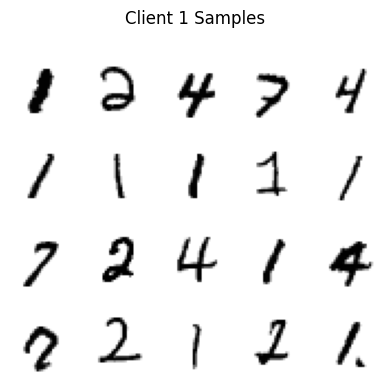

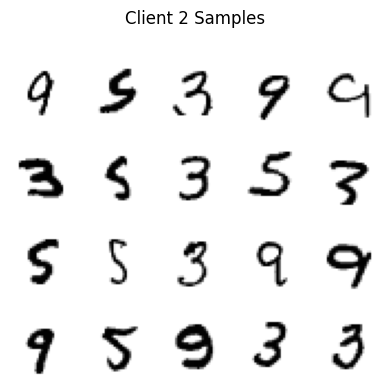

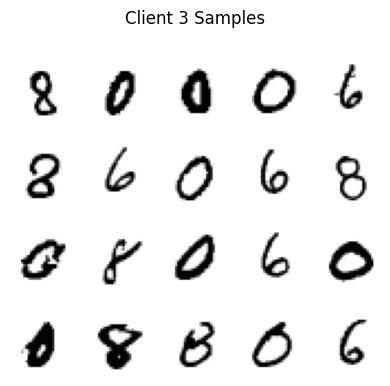

In [113]:
mnist_non_iid_train, mnist_non_iid_test = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True, shuffle_digits=False)

# Plot samples for client 1
plot_samples(next(iter(mnist_non_iid_train[0])), channel=0, title="Client 1 Samples")

# Plot samples for client 2
plot_samples(next(iter(mnist_non_iid_train[1])), channel=0, title="Client 2 Samples")

# Plot samples for client 3
plot_samples(next(iter(mnist_non_iid_train[2])), channel=0, title="Client 3 Samples")

plt.show()

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [114]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [115]:
'''def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """

    params_1 = list(model_1.parameters())
    params_2 = list(model_2.parameters())

    if len(params_1) != len(params_2):
        raise ValueError("The two models have different number of parameters.")
    
    return sum([(params_1[i] - params_2[i]).norm(2).item()**2 for i in range(len(params_1))])'''
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    params_1 = list(model_1.parameters())
    params_2 = list(model_2.parameters())

    if len(params_1) != len(params_2):
        raise ValueError("The two models do not have the same number of parameters.")
    
    diff = sum([(p1 - p2).pow(2).sum() for p1, p2 in zip(params_1, params_2)])
    return diff.item()

Here is the function to perform one epoch of training data.

In [116]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [117]:
from copy import deepcopy

def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):

    ### Copy model to a new variable ###
    local_model = deepcopy(model)

    for epoch in range(epochs):
        local_loss=train_step(model, local_model, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [118]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [119]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [120]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model=deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer=optim.SGD(local_model.parameters(),lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss=local_learning(local_model, mu, local_optimizer,
                training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [121]:
# use fedprox to train the model
model = CNN()
global_model, loss_hist, acc_hist = FedProx(model, training_sets=mnist_iid_train, n_iter=10, testing_sets=mnist_iid_test, mu=0, epochs=5, lr=1e-2)


Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3029817740122476 Server Test Accuracy: 8.0


====> i: 1 Loss: 2.233847141265869 Server Test Accuracy: 46.33333333333333
====> i: 2 Loss: 2.1408181190490723 Server Test Accuracy: 50.33333333333333
====> i: 3 Loss: 1.9675012826919556 Server Test Accuracy: 61.33333333333333
====> i: 4 Loss: 1.5984568198521931 Server Test Accuracy: 69.0
====> i: 5 Loss: 1.046341816584269 Server Test Accuracy: 77.0
====> i: 6 Loss: 0.6603359778722127 Server Test Accuracy: 84.0
====> i: 7 Loss: 0.4767200152079264 Server Test Accuracy: 85.66666666666666
====> i: 8 Loss: 0.37110314766565955 Server Test Accuracy: 88.0
====> i: 9 Loss: 0.30663275718688965 Server Test Accuracy: 89.33333333333333
====> i: 10 Loss: 0.25687330961227417 Server Test Accuracy: 89.33333333333333


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

In [122]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
  plt.figure(figsize=(12, 6))

  # Plot Loss
  plt.subplot(1, 2, 1)
  for i in range(len(loss_hist[0])):
      plt.plot(np.arange(len(loss_hist)), [loss_hist[j][i] for j in range(len(loss_hist))], label=f'Client {i+1}')

  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title(f'{title} - Loss')
  plt.legend()

  # Plot Accuracy
  plt.subplot(1, 2, 2)
  for i in range(len(acc_hist[0])):
      plt.plot(np.arange(len(acc_hist)), [acc_hist[j][i] for j in range(len(acc_hist))], label=f'Client {i+1}')

  plt.xlabel('Iterations')
  plt.ylabel('Accuracy (%)')
  plt.title(f'{title} - Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

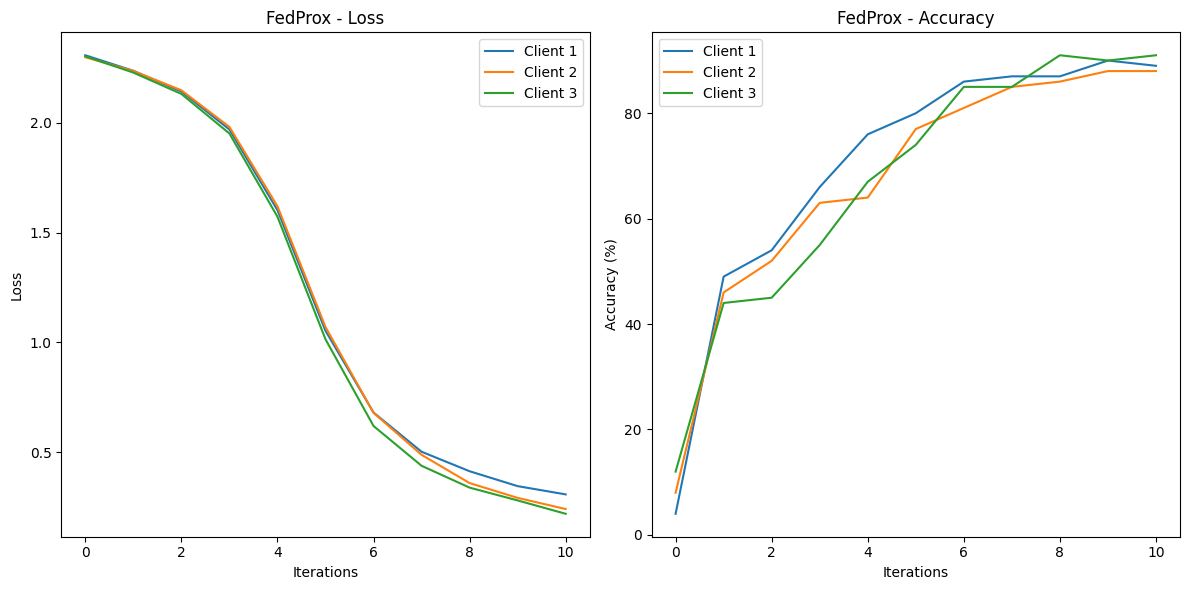

In [123]:
plot_acc_loss("FedProx", loss_hist, acc_hist)

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3127431869506836 Server Test Accuracy: 10.666666666666666
====> i: 1 Loss: 2.0132028261820474 Server Test Accuracy: 52.33333333333333
====> i: 2 Loss: 1.002214511235555 Server Test Accuracy: 65.0
====> i: 3 Loss: 0.6407979130744934 Server Test Accuracy: 78.0
====> i: 4 Loss: 0.27073704202969867 Server Test Accuracy: 89.66666666666666
====> i: 5 Loss: 0.17846838136514026 Server Test Accuracy: 91.66666666666666
====> i: 6 Loss: 0.20182907084623972 Server Test Accuracy: 90.66666666666666
====> i: 7 Loss: 0.09131298462549844 Server Test Accuracy: 93.0
====> i: 8 Loss: 0.07044563939174016 Server Test Accuracy: 94.66666666666666
====> i: 9 Loss: 0.05601720387736956 Server Test Accuracy: 94.33333333333333
====> i: 10 Loss: 0.042127860710024834 Server Test Accuracy: 95.0


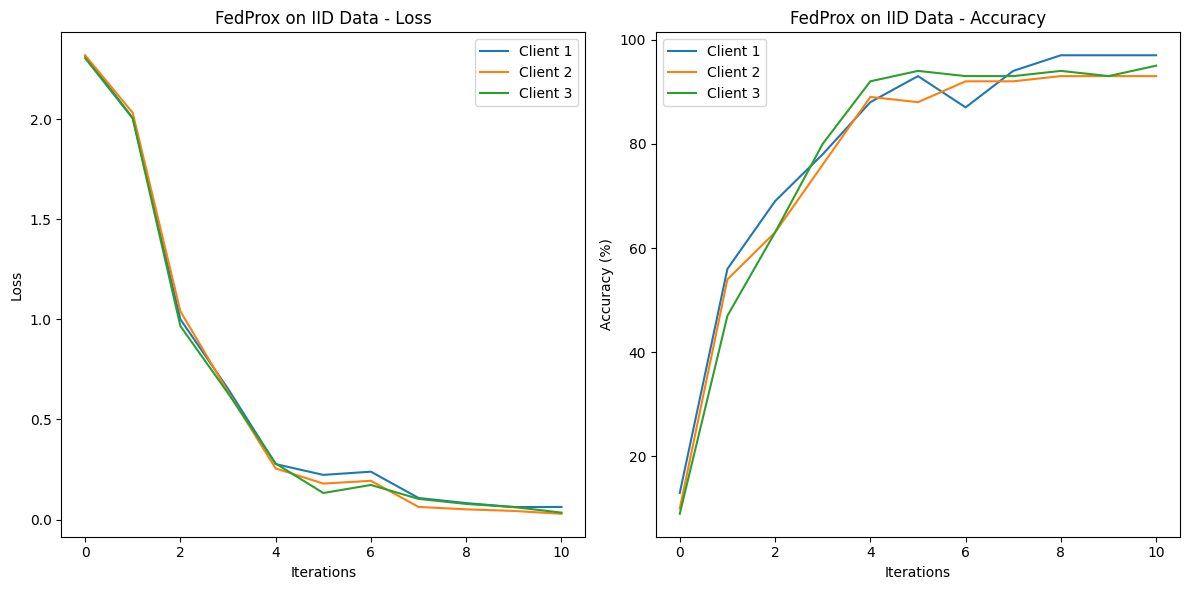

In [124]:
model_0 = CNN()
n_iter = 10
local_epochs = 2
lr = 0.1
mu = 0.3

# Define your training and testing data (e.g., mnist_iid_train and mnist_iid_test)

# Perform Federated Learning with FedProx
final_model, loss_hist, acc_hist = FedProx(
    model_0,
    training_sets=mnist_iid_train,
    n_iter=n_iter,
    testing_sets=mnist_iid_test,
    mu=mu,
    epochs=local_epochs,
    lr=lr,
    decay=1.0
)

# Plot the accuracy and loss
plot_acc_loss("FedProx on IID Data", loss_hist, acc_hist)

4) What do you observe ?

We observe a rapid increase (decrease) of the accuracy (loss) inside the test set. The accuracy and loss seems to be the same (approximately) for the 3 clients.  
On FedProx approach the curb is more stable than on FedAvg.

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

In [125]:
# Non iid data
model_0= CNN()
n_iter = 25
local_epochs = 5
lr = 0.01
mu = 0.0

final_model, loss_hist, acc_hist = FedProx(
    model_0,
    training_sets=mnist_non_iid_train,
    n_iter=n_iter,
    testing_sets=mnist_non_iid_test,
    mu=mu,
    epochs=local_epochs,
    lr=lr,
    decay=1.0
)

Clients' weights: [0.4066666666666667, 0.2866666666666667, 0.30666666666666664]
====> i: 0 Loss: 2.3080934349695843 Server Test Accuracy: 12.154595668094085
====> i: 1 Loss: 2.2622290674845376 Server Test Accuracy: 13.038167938931299
====> i: 2 Loss: 2.1452325344085694 Server Test Accuracy: 34.93667924307566
====> i: 3 Loss: 1.9655346171061199 Server Test Accuracy: 42.649410663624934
====> i: 4 Loss: 1.6997694047292076 Server Test Accuracy: 47.16080112367325
====> i: 5 Loss: 1.4355798133214315 Server Test Accuracy: 57.2350283308045
====> i: 6 Loss: 1.225907348791758 Server Test Accuracy: 65.34960276952071
====> i: 7 Loss: 1.0736776916186015 Server Test Accuracy: 69.919036602843
====> i: 8 Loss: 0.9329049150149028 Server Test Accuracy: 74.20117118254626
====> i: 9 Loss: 0.8466533827781677 Server Test Accuracy: 76.38574478663976
====> i: 10 Loss: 0.773227123816808 Server Test Accuracy: 78.71831340582425
====> i: 11 Loss: 0.7103311510880788 Server Test Accuracy: 79.4653521002175
====> i: 

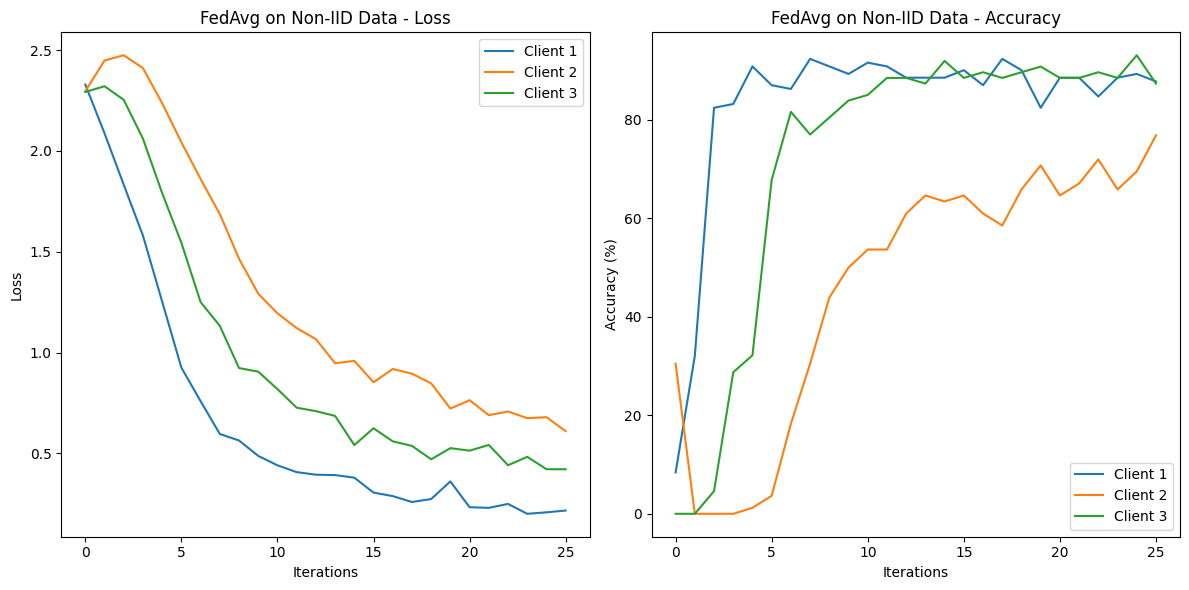

In [126]:
plot_acc_loss("FedAvg on Non-IID Data", loss_hist, acc_hist)

In [127]:
model_0 = CNN()

mu = 0.3

final_model, loss_hist, acc_hist = FedProx(
    model_0,
    training_sets=mnist_iid_train,
    n_iter=n_iter,
    testing_sets=mnist_iid_test,
    mu=mu,
    epochs=local_epochs,
    lr=lr,
    decay=1.0
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3037686347961426 Server Test Accuracy: 7.666666666666666
====> i: 1 Loss: 2.228425105412801 Server Test Accuracy: 23.666666666666664
====> i: 2 Loss: 2.121187448501587 Server Test Accuracy: 43.33333333333333
====> i: 3 Loss: 1.90825875600179 Server Test Accuracy: 58.33333333333333
====> i: 4 Loss: 1.4627946615219116 Server Test Accuracy: 68.33333333333333
====> i: 5 Loss: 0.9124277035395303 Server Test Accuracy: 81.66666666666666
====> i: 6 Loss: 0.5890052914619446 Server Test Accuracy: 85.66666666666666
====> i: 7 Loss: 0.44064575433731074 Server Test Accuracy: 86.66666666666666
====> i: 8 Loss: 0.35395569602648413 Server Test Accuracy: 85.66666666666666
====> i: 9 Loss: 0.2962619364261627 Server Test Accuracy: 90.0
====> i: 10 Loss: 0.2571591337521871 Server Test Accuracy: 89.0
====> i: 11 Loss: 0.22883642713228858 Server Test Accuracy: 89.33333333333333
====> i: 12 Loss: 0.2000973373651

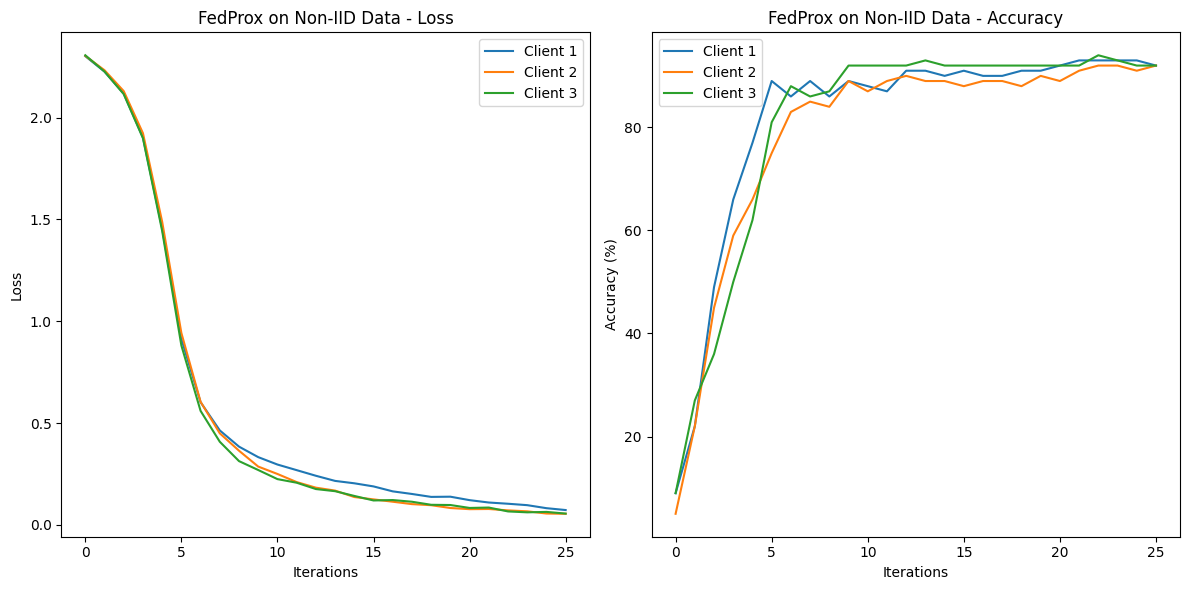

In [128]:
plot_acc_loss("FedProx on Non-IID Data", loss_hist, acc_hist)

2) What do you observe ?

Again almost same curves for the clients, but this time the accuracy and loss are lower than for the non-iid data.  
Also the FedProx approach seems to be quicker and safer than the FedAvg approach on Non-iid data.

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [129]:
!pip install medmnist

Defaulting to user installation because normal site-packages is not writeable


Import medmnist

In [130]:
import medmnist

You can list all available datasets with this command

In [131]:
!python3 -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [132]:
from medmnist import BloodMNIST

In [133]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [134]:
# Define a preprocessing pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=0.5, std=0.5)  # Normalize the pixel values
])

# Load the BloodMNIST dataset
dataset = BloodMNIST(root='./data/', split='train', transform=transform, download=True)

Using downloaded and verified file: ./data/bloodmnist.npz


3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [135]:
class CustomDataset(data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [136]:
# Split the dataset into train and test
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_data = CustomDataset(train_dataset)
test_data = CustomDataset(test_dataset)

4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

In [137]:
def show_sample(image, label, title=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(image[0], cmap='gray')
    plt.title(f"{title} label: {label}")
    plt.axis('off')
    plt.show()

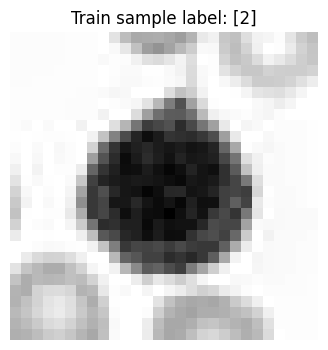

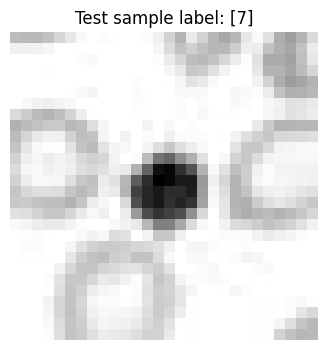

In [138]:
show_sample(*train_data[0], title="Train sample")
show_sample(*test_data[1], title="Test sample")

5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [139]:
batch_size = 128
shuffle = True

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)

6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [159]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_labels=False):
    assert nb_nodes > 0 and nb_nodes <= 10

    labels = torch.arange(8) if not shuffle_labels else torch.randperm(8, generator=torch.Generator().manual_seed(0))

    # Split the labels evenly among nodes
    labels_per_node = 8 // nb_nodes
    labels_split = [labels[i * labels_per_node : (i + 1) * labels_per_node] for i in range(nb_nodes)]
    # If there are remaining labels, distribute them among all nodes starting from the first one
    remaining_labels = labels[labels_per_node * nb_nodes :]
    for i, label in enumerate(remaining_labels):
        labels_split[i % nb_nodes] = torch.cat((labels_split[i % nb_nodes], label.view(1)))

    labels = np.array([label for _, label in dataset])

    data_splitted = list()
    for i in range(nb_nodes):
        idx = np.where(np.isin(labels, labels_split[i]))[0].tolist()
        
        dataset_node = torch.utils.data.Subset(dataset, idx[:n_samples_per_node])
        loader_node = DataLoader(dataset_node, batch_size=batch_size, shuffle=shuffle)
        # Append data_splitted with the current data loader
        data_splitted.append(loader_node)

    # Return data_splitted with all data loaders
    return data_splitted


In [141]:
def get_BloodMNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True, shuffle_labels=False):
    # Step 1: Load BloodMNIST Dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = BloodMNIST(root='./data', split='train', transform=transform, download=True)
    test_dataset = BloodMNIST(root='./data', split='test', transform=transform, download=True)

    # Step 2: Apply Split Function Based on the Type Parameter
    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle, shuffle_labels=True)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle, shuffle_labels=True)
    else:
        raise ValueError("Invalid type parameter. Use 'iid' or 'non_iid'.")

    return train_loaders, test_loaders

In [142]:
def plot_samples(data, channel=0, title=None, plot_name="", n_examples=20):
    n_rows = int(n_examples / 5)
    plt.figure(figsize=(2 * n_rows, 2 * n_rows))
    if title:
        plt.suptitle(title)
    X, y = data
    for idx in range(n_examples):
        ax = plt.subplot(n_rows, 5, idx + 1)
        image = 255 - X[idx, channel].view((28, 28))
        ax.imshow(image, cmap='gist_gray')
        ax.set_title(f"Label: {y[idx]}")
        ax.axis("off")
    if plot_name != "":
        plt.savefig(f"plots/{plot_name}.png")
    plt.tight_layout()
    plt.show()

### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [143]:
train_loaders_iid, test_loaders_iid = get_BloodMNIST(
    type="iid",
    n_samples_train=200,
    n_samples_test=100,
    n_clients=3,
    batch_size=batch_size,
    shuffle=True
)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


2. plost samples with corresponding function.

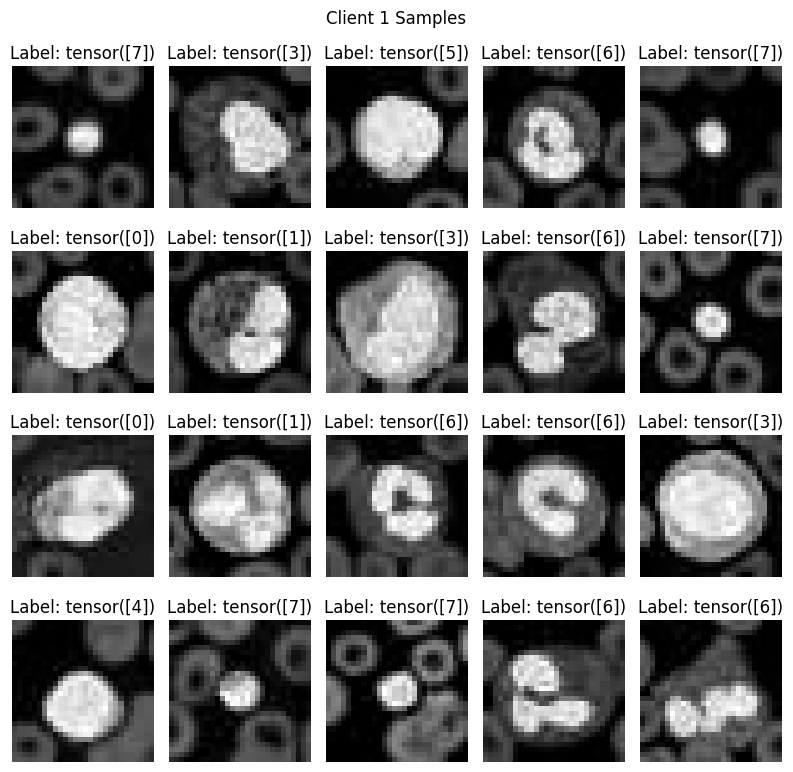

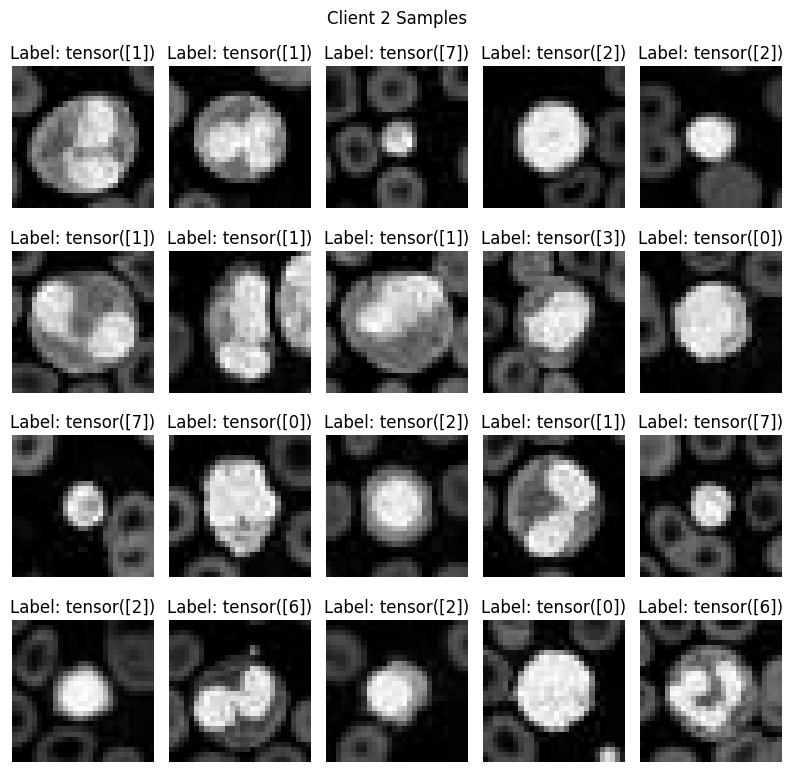

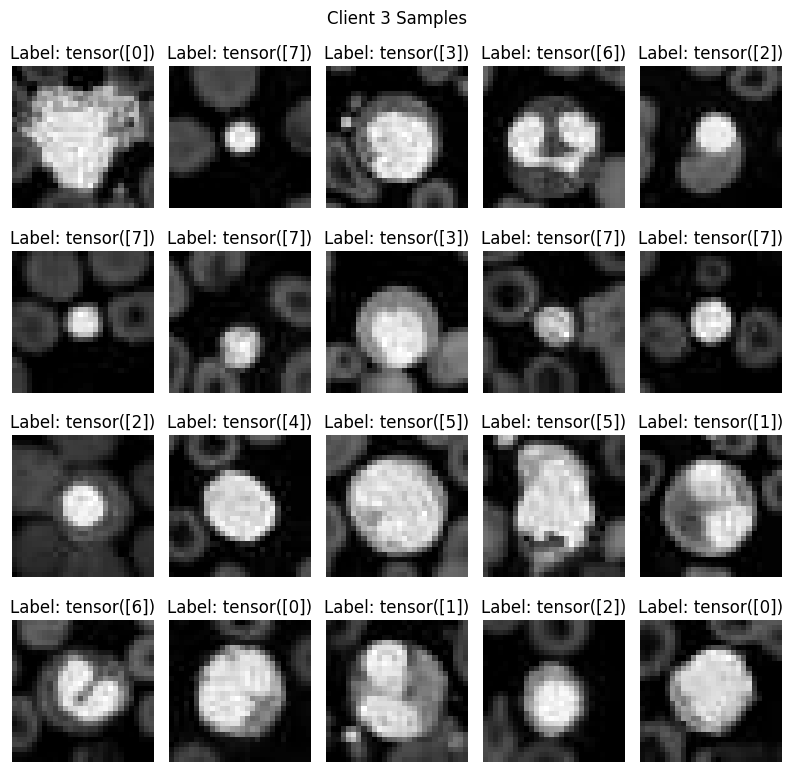

In [144]:
plot_samples(next(iter(train_loaders_iid[0])), channel=0, title="Client 1 Samples")
plot_samples(next(iter(train_loaders_iid[1])), channel=0, title="Client 2 Samples")
plot_samples(next(iter(train_loaders_iid[2])), channel=0, title="Client 3 Samples")

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [145]:
class CNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input channels=3 for RGB images
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        # Second convolutional layer with MaxPooling
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Third convolutional layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # Fourth convolutional layer
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # Fifth convolutional layer with MaxPooling
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(3136, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        # Flatten before passing to fully connected layers
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [146]:
model_0 = CNN()

n_iter = 10
local_epochs = 5
lr = 0.01
mu = 0.0

final_model, loss_hist, acc_hist = FedProx(
    model_0,
    training_sets=train_loaders_iid,
    n_iter=n_iter,
    testing_sets=test_loaders_iid,
    mu=mu,
    epochs=local_epochs,
    lr=lr,
    decay=1.0
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.169949531555176 Server Test Accuracy: 10.666666666666666
====> i: 1 Loss: 1.5694994529088335 Server Test Accuracy: 46.0
====> i: 2 Loss: 1.2615629434585571 Server Test Accuracy: 53.0
====> i: 3 Loss: 1.0417356491088867 Server Test Accuracy: 60.66666666666666
====> i: 4 Loss: 0.9088794390360514 Server Test Accuracy: 66.0
====> i: 5 Loss: 0.7186843355496724 Server Test Accuracy: 70.33333333333333
====> i: 6 Loss: 0.6562496821085612 Server Test Accuracy: 70.33333333333333
====> i: 7 Loss: 0.5679485996564229 Server Test Accuracy: 76.33333333333333
====> i: 8 Loss: 0.4940122663974762 Server Test Accuracy: 74.0
====> i: 9 Loss: 0.44735420743624366 Server Test Accuracy: 77.33333333333333
====> i: 10 Loss: 0.3936014076073964 Server Test Accuracy: 79.0


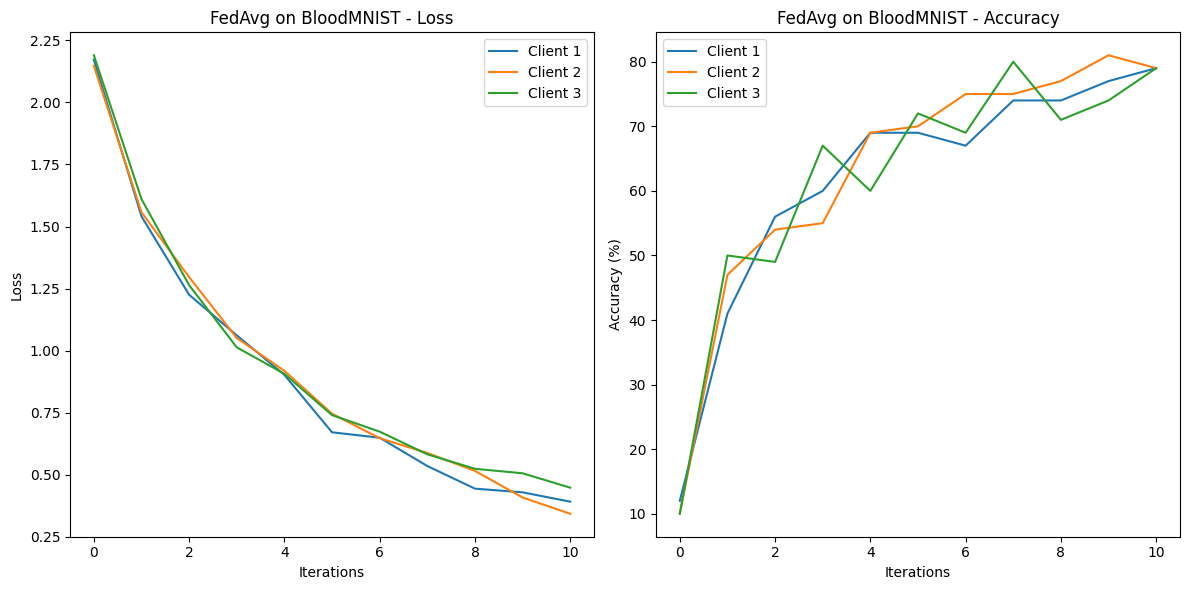

In [147]:
plot_acc_loss("FedAvg on BloodMNIST", loss_hist, acc_hist)

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

In [148]:
model_0 = CNN()
mu = 0.3

final_model, loss_hist, acc_hist = FedProx(
    model_0,
    training_sets=train_loaders_iid,
    n_iter=n_iter,
    testing_sets=test_loaders_iid,
    mu=mu,
    epochs=local_epochs,
    lr=lr,
    decay=1.0
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.1885143915812173 Server Test Accuracy: 12.666666666666666
====> i: 1 Loss: 1.609728693962097 Server Test Accuracy: 41.0
====> i: 2 Loss: 1.2714585463205972 Server Test Accuracy: 53.0
====> i: 3 Loss: 1.1026381651560464 Server Test Accuracy: 60.33333333333333
====> i: 4 Loss: 0.944438854853312 Server Test Accuracy: 61.99999999999999
====> i: 5 Loss: 0.7879421313603718 Server Test Accuracy: 69.0
====> i: 6 Loss: 0.7015717426935831 Server Test Accuracy: 69.66666666666666
====> i: 7 Loss: 0.6095272699991862 Server Test Accuracy: 76.0
====> i: 8 Loss: 0.5105902353922526 Server Test Accuracy: 74.66666666666666
====> i: 9 Loss: 0.4863691528638204 Server Test Accuracy: 75.0
====> i: 10 Loss: 0.46303174893061316 Server Test Accuracy: 74.0


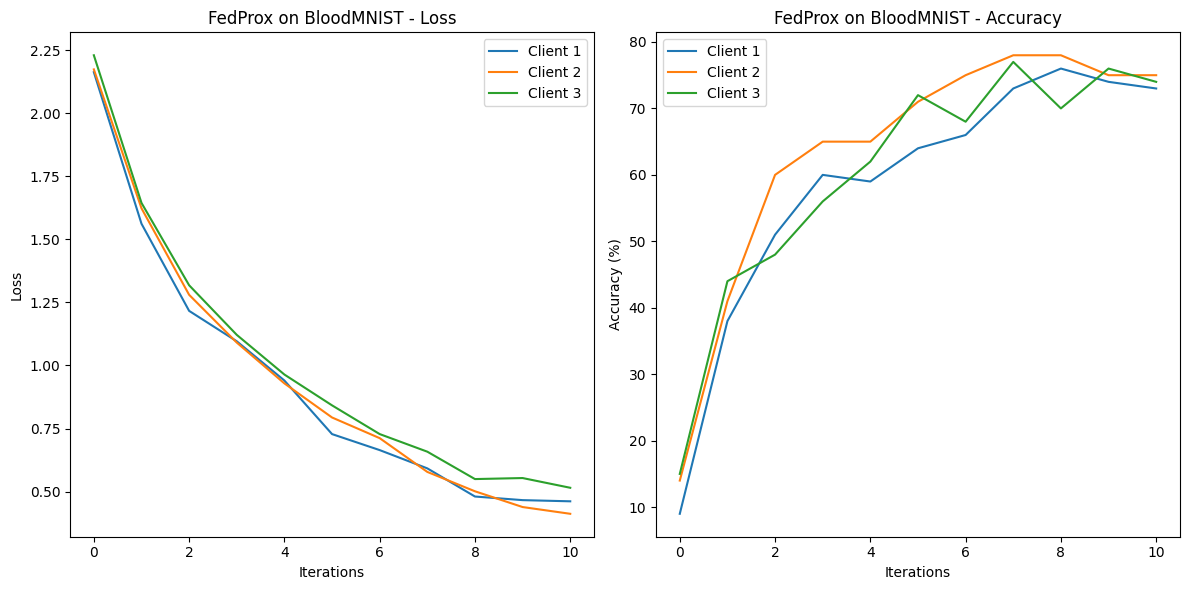

In [149]:
plot_acc_loss("FedProx on BloodMNIST", loss_hist, acc_hist)

This time FedAvg seems to be the better approach into finding the best accuracy.

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

In [160]:
# Same thin but with non iid
train_loaders_non_iid, test_loaders_non_iid = get_BloodMNIST(
    type="non_iid",
    n_samples_train=200,
    n_samples_test=100,
    n_clients=3,
    batch_size=batch_size,
    shuffle=True,
    shuffle_labels=True
)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


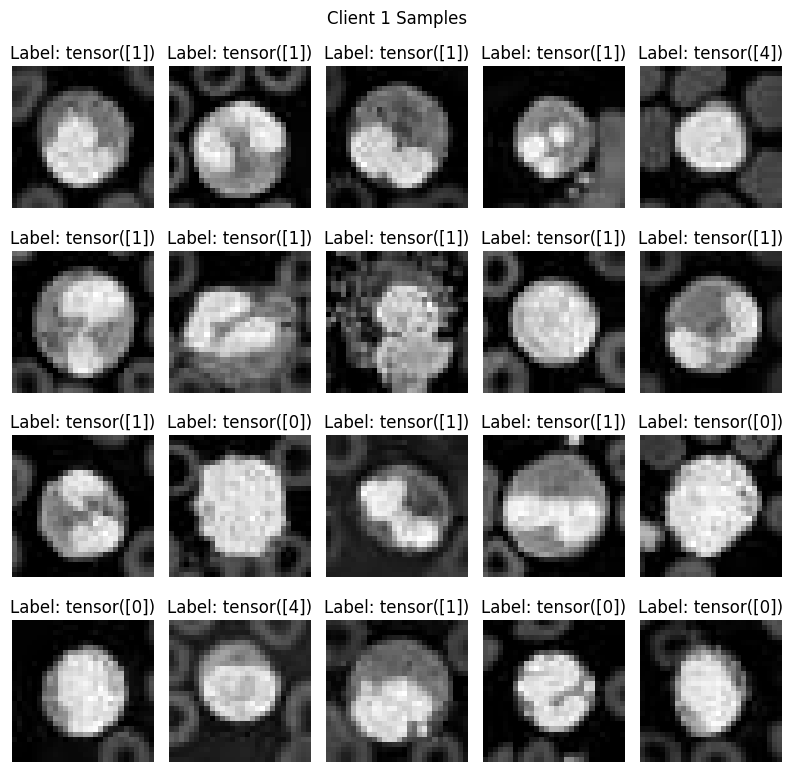

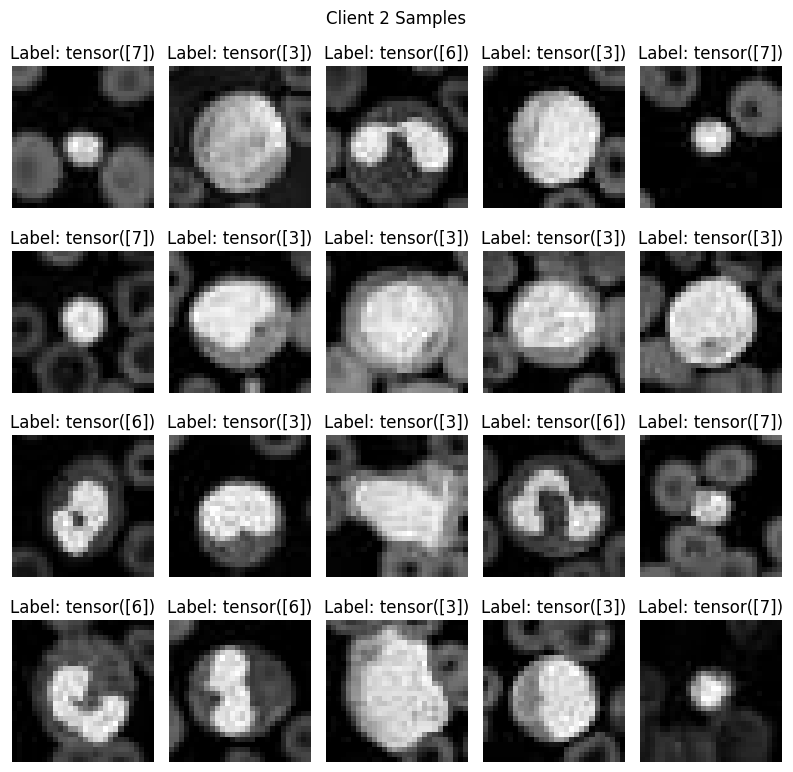

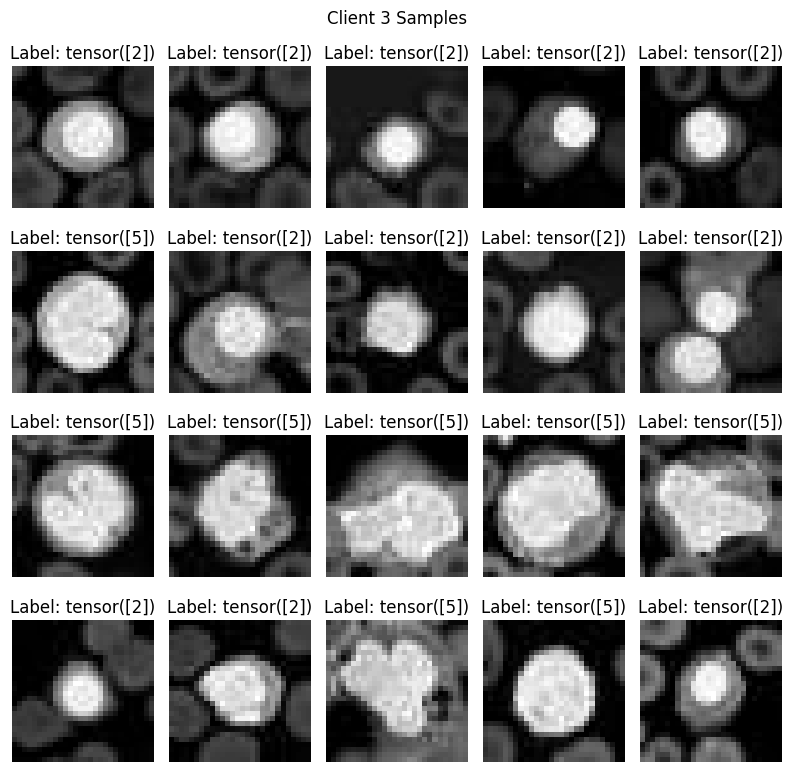

In [161]:
plot_samples(next(iter(train_loaders_non_iid[0])), channel=0, title="Client 1 Samples")
plot_samples(next(iter(train_loaders_non_iid[1])), channel=0, title="Client 2 Samples")
plot_samples(next(iter(train_loaders_non_iid[2])), channel=0, title="Client 3 Samples")

In [162]:
model_0 = CNN()

mu=0.0

final_model, loss_hist, acc_hist = FedProx(
    model_0,
    training_sets=train_loaders_non_iid,
    n_iter=n_iter,
    testing_sets=test_loaders_non_iid,
    mu=mu,
    epochs=local_epochs,
    lr=lr,
    decay=1.0
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.164087136586507 Server Test Accuracy: 10.666666666666666
====> i: 1 Loss: 1.8937249183654785 Server Test Accuracy: 25.333333333333332
====> i: 2 Loss: 1.6975989739100137 Server Test Accuracy: 31.33333333333333
====> i: 3 Loss: 1.5306770404179888 Server Test Accuracy: 42.666666666666664
====> i: 4 Loss: 1.4056835174560547 Server Test Accuracy: 45.666666666666664
====> i: 5 Loss: 1.3447682857513428 Server Test Accuracy: 44.33333333333333
====> i: 6 Loss: 1.248440663019816 Server Test Accuracy: 50.0
====> i: 7 Loss: 1.1620099941889444 Server Test Accuracy: 52.666666666666664
====> i: 8 Loss: 1.154478629430135 Server Test Accuracy: 56.99999999999999
====> i: 9 Loss: 1.0740183591842651 Server Test Accuracy: 60.666666666666664
====> i: 10 Loss: 0.9997152487436929 Server Test Accuracy: 54.666666666666664


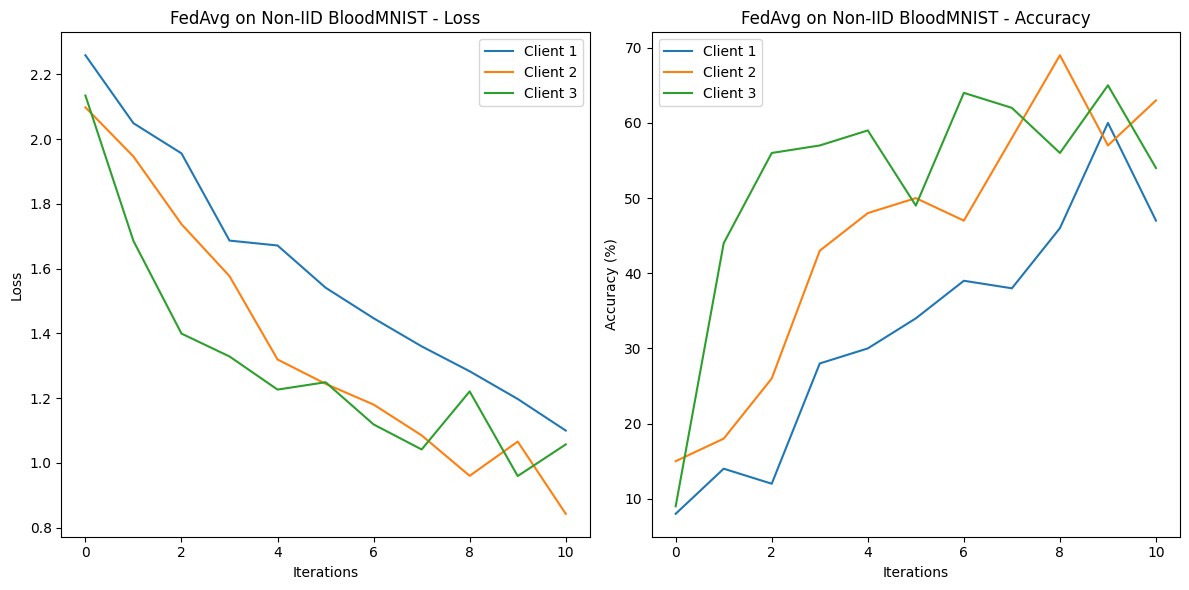

In [163]:
plot_acc_loss("FedAvg on Non-IID BloodMNIST", loss_hist, acc_hist)

In [164]:
model_0 = CNN()
mu = 0.3

final_model, loss_hist, acc_hist = FedProx(
    model_0,
    training_sets=train_loaders_non_iid,
    n_iter=n_iter,
    testing_sets=test_loaders_non_iid,
    mu=mu,
    epochs=local_epochs,
    lr=lr,
    decay=1.0
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.156282107035319 Server Test Accuracy: 12.666666666666666
====> i: 1 Loss: 1.8667905330657957 Server Test Accuracy: 28.33333333333333
====> i: 2 Loss: 1.6466765403747556 Server Test Accuracy: 41.0
====> i: 3 Loss: 1.522616108258565 Server Test Accuracy: 36.0
====> i: 4 Loss: 1.42697004477183 Server Test Accuracy: 46.666666666666664
====> i: 5 Loss: 1.293352723121643 Server Test Accuracy: 45.0
====> i: 6 Loss: 1.2398045460383096 Server Test Accuracy: 47.66666666666666
====> i: 7 Loss: 1.1447078784306843 Server Test Accuracy: 52.66666666666666
====> i: 8 Loss: 1.110965371131897 Server Test Accuracy: 55.99999999999999
====> i: 9 Loss: 1.0504156351089478 Server Test Accuracy: 60.33333333333333
====> i: 10 Loss: 1.0166229009628296 Server Test Accuracy: 57.0


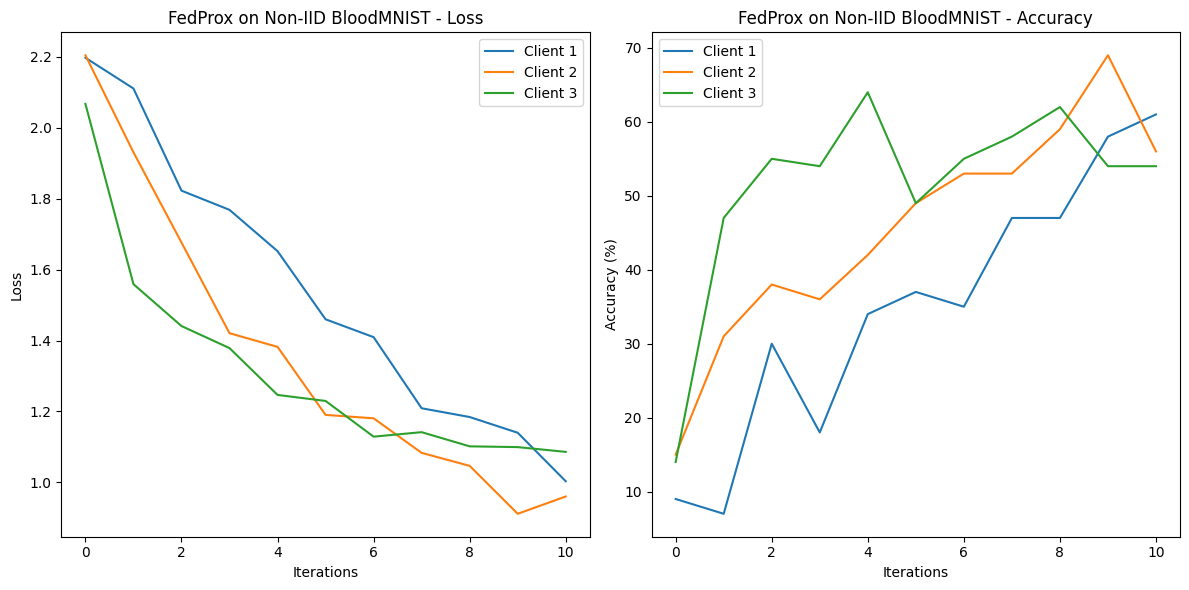

In [165]:
plot_acc_loss("FedProx on Non-IID BloodMNIST", loss_hist, acc_hist)

Non-iid creates differences in the client curves. The accuracy and loss are lower than for the iid data.

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf